# 小林里梨香さん・村田さんの卒研：トマトの成熟度の判別
農業トマトの画像物体検出用データセット『Laboro Tomato』

概要 (日本語):  
https://laboro.ai/activity/column/engineer/laboro-tomato/

詳細 (英語):  
https://github.com/laboroai/LaboroTomato?_fsi=2ONcfTup&_fsi=2ONcfTup

In [24]:
# Bounding box 情報を利用して切り出したトマト画像の一覧を得る
parent_dir = "Cropped_Big/"

import pandas as pd
df = pd.read_csv(parent_dir + "train/tomato_big_annotation.txt", header=None, delimiter='\t')
df.columns = ['image_filename', "class"]

# クラス番号が 1 から始まっている(1〜3)ため，これを 0 オリジン(0〜2)へ書き換える
df['class'] = df['class'] - 1

df

,image_filename,class
0,IMG_20191215_111114-1.jpg,2
1,IMG_20191215_111114-2.jpg,1
2,IMG_20191215_111114-3.jpg,2
3,IMG_20191215_111114-4.jpg,0
4,IMG_20191215_111114-5.jpg,1
...,...,...
2202,IMG_20191215_111751-5.jpg,2
2203,IMG_20191215_111751-6.jpg,2
2204,IMG_20191215_111751-7.jpg,2
2205,IMG_20191215_111751-8.jpg,2


In [25]:
# 画像数 → 2207枚
len(df)

2207

In [4]:
# データセットを作る

# 画像のファイル名(正確にはパス名)
X = (parent_dir + "train/" + df['image_filename']).tolist()

# クラス(完熟，半熟，緑熟)
y = df['class'].tolist()

In [5]:
# (参考) X はこんな感じ
print(X[:5])

['Cropped_Big/train/IMG_20191215_111114-1.jpg', 'Cropped_Big/train/IMG_20191215_111114-2.jpg', 'Cropped_Big/train/IMG_20191215_111114-3.jpg', 'Cropped_Big/train/IMG_20191215_111114-4.jpg', 'Cropped_Big/train/IMG_20191215_111114-5.jpg']


In [6]:
# (参考) y はこんな感じ
print(y[:5])

[2, 1, 2, 0, 1]


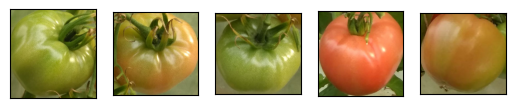

In [26]:
# (確認) データの先頭の画像を表示
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

fig = plt.figure()
for idx in range(5):
    image_filename = X[idx]
    class_number = y[idx] ##### (メモ) 使っていない変数
    
    img = Image.open(image_filename)
    
    # print(idx)
    fig.add_subplot(1, 5, idx+1)
    plt.imshow(img)
    
    # 軸ラベル，補助線を消す
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
    # plt.legend()
    
    img.close()
plt.show()

In [8]:
# (確認) 全画像サイズのチェック → ばらついているのが明らか
from PIL import Image

image_sizes = list()
for path in X:
    im = Image.open(path)
    image_sizes.append(im.size)
    im.close()
    
print(set(image_sizes))

{(819, 826), (218, 191), (736, 791), (622, 577), (1101, 1069), (193, 283), (199, 214), (382, 335), (1412, 1641), (861, 827), (312, 356), (732, 713), (205, 230), (224, 243), (652, 690), (494, 512), (308, 242), (501, 557), (492, 588), (607, 538), (374, 452), (474, 539), (286, 339), (287, 304), (518, 582), (190, 142), (529, 511), (459, 532), (211, 201), (157, 230), (244, 198), (110, 118), (528, 631), (494, 489), (441, 483), (646, 623), (244, 234), (256, 208), (861, 696), (738, 742), (344, 586), (365, 380), (258, 254), (350, 337), (427, 211), (997, 858), (221, 228), (184, 197), (558, 487), (905, 860), (453, 205), (350, 458), (243, 246), (663, 689), (217, 194), (90, 153), (284, 284), (93, 307), (334, 370), (254, 261), (1228, 1141), (357, 353), (409, 400), (195, 211), (127, 156), (974, 995), (861, 938), (534, 580), (147, 134), (565, 647), (207, 185), (1067, 1043), (198, 216), (264, 310), (610, 655), (117, 148), (172, 163), (1100, 1076), (272, 287), (291, 300), (372, 374), (472, 461), (224, 2

In [27]:
# (確認) 各クラスのサンプル数の確認
import collections
collections.Counter(y)

Counter({2: 1403, 1: 477, 0: 327})

(メモ) negative / positive sample 数は，Kaggle のページにある説明と同じ数値となる。
```
total: neg:198738, pos:78786
```

In [7]:
# 学習／テストへのデータセット分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/home/muto/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [11]:
# Dataset クラスの定義

import numpy as np
from PIL import Image
from pathlib import Path
import torch
# import torch.utils.data as data
from torchvision import transforms

# Transformer の定義
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.CenterCrop(100),
    # transforms.Grayscale(num_output_channels=3), # ResNet 等に喰わせるため，あえて３チャネル
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset : データソースから1個ずつデータを取り出すクラス
# 実装が必要なメソッドは__getitem__と__len__の2つ
# https://ohke.hateblo.jp/entry/2019/12/28/230000

# (メモ) このデータセットで transform=None はあり得ない！！
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None): #, input_size):
        super().__init__()
        
        self.transform = transform
        self.image_paths = image_paths
        self.labels = labels
        self.len = len(self.image_paths)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        
        # 入力
        image = Image.open(image_path)
        
        # covert RGBA to RGB
        # Oxford-III Pet Dataset に少数ながら 'RGBA' が含まれるため，
        # これを RGB へ変換する
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        
        '''
        if self.transform:
            image = self.transform(image_array)
        else:
            image = torch.Tensor(np.transpose(image_array, (2, 0, 1)))/255  # for 0~1 scaling
        '''
        if self.transform:
            image = self.transform(image)
        else:
            image = np.asarray(image)
            image = torch.from_numpy(image)
                
        return image, label

train_dataset = MyDataset(X_train, y_train, transform=transform) #, (224, 224))
test_dataset = MyDataset(X_test, y_test, transform=transform) #, (224, 224))

# 動作チェック
image, label = train_dataset[0]
print(image.size(), label)  # torch.Size([3, 256, 256]) 1
print(type(image))
print(type(label))

torch.Size([3, 128, 128]) 2
<class 'torch.Tensor'>
<class 'int'>


In [12]:
# DataLoader の定義

BATCH_SIZE = 16 # 32 # 64 # 128 # 16

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, drop_last=True
)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, drop_last=True
)

# 動作チェック
images, labels = next(iter(trainloader))
print(images.size())  # torch.Size([16, 3, 224, 224])
print(labels.size())  # torch.Size([16])

torch.Size([16, 3, 128, 128])
torch.Size([16])


In [19]:
# モデル / optimizer / criterion の定義

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# GPUあれば使う
def check_cuda():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = torch.device(check_cuda()) # "cuda"

import sys
print("device: {}".format(device), file=sys.stderr)

num_classes = 3 # クラス数

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(4)
        self.fc = nn.Linear(128*3*3, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # print("before avg:", x.shape)
        x = self.avg(x)
        # print("before:", x.shape) # torch.Size([16, 128, 3, 3])
        x = x.view(-1, 128*3*3)
        # print("after:", x.shape)
        x = self.fc(x)
        return x

net = Net()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.005)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (fc): Linear(in_features=1152, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


device: cuda


In [20]:
from tqdm import tqdm

# 学習
# https://qiita.com/mathlive/items/8e1f9a8467fff8dfd03c

EPOCH = 30

train_loss_value=[]      #trainingのlossを保持するlist
train_acc_value=[]       #trainingのaccuracyを保持するlist
test_loss_value=[]       #tes%MCEPASTEBIN%tのlossを保持するlist
test_acc_value=[]        #testのaccuracyを保持するlist 

for epoch in range(EPOCH):
    print('epoch', epoch+1)    #epoch数の出力

    # 学習
    net.train() # 学習モード
    for (inputs, labels) in trainloader: # tqdm(trainloader):
        # print("inputs", inputs.shape)
        # print("labels", labels.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        #print(predicted)
        #print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    #train dataを使ってテストをする(パラメータ更新がないようになっている)
    sum_loss = 0.0          #lossの合計
    sum_correct = 0         #正解率の合計
    sum_total = 0           #dataの数の合計

    net.eval() # 評価モード
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()                            #lossを足していく
        _, predicted = outputs.max(1)                      #出力の最大値の添字(予想位置)を取得
        sum_total += labels.size(0)                        #labelの数を足していくことでデータの総和を取る
        sum_correct += (predicted == labels).sum().item()  #予想位置と実際の正解を比べ,正解している数だけ足す
    print("train mean loss={}, accuracy={}"
            .format(sum_loss*BATCH_SIZE/len(trainloader.dataset), float(sum_correct/sum_total)))  #lossとaccuracy出力
    train_loss_value.append(sum_loss*BATCH_SIZE/len(trainloader.dataset))  #traindataのlossをグラフ描画のためにlistに保持
    train_acc_value.append(float(sum_correct/sum_total))   #traindataのaccuracyをグラフ描画のためにlistに保持

    '''
    with open("/home/muto/Dropbox/20201230.txt", 'a') as fp:
        print('epoch{}'.format(epoch+1), file=fp)
        print("train  mean loss={}, accuracy={}"
              .format(sum_loss*BATCH_SIZE/len(trainloader.dataset), float(sum_correct/sum_total)), file=fp)
    '''
        
    #test dataを使ってテストをする
    sum_loss = 0.0
    sum_correct = 0
    sum_total = 0

    cm_predicted_list = [] # confusion matrix で利用するため予測値を蓄える
    cm_true_list = [] # confusion matrix で利用するため真値を蓄える
    
    net.eval() # 評価モード
    for (inputs, labels) in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()
        _, predicted = outputs.max(1)
        sum_total += labels.size(0)
        sum_correct += (predicted == labels).sum().item()
        
        # confusion matrix のため予測値／真値を蓄える
        cm_predicted_list += predicted.tolist()
        cm_true_list += labels.tolist()
    print("test  mean loss={}, accuracy={}"
            .format(sum_loss*BATCH_SIZE/len(testloader.dataset), float(sum_correct/sum_total)))
    test_loss_value.append(sum_loss*BATCH_SIZE/len(testloader.dataset))
    test_acc_value.append(float(sum_correct/sum_total))

    '''
    with open("/home/muto/Dropbox/20201230.txt", 'a') as fp:
        print("test  mean loss={}, accuracy={}"
              .format(sum_loss*BATCH_SIZE/len(testloader.dataset), float(sum_correct/sum_total)), file=fp)
    '''

epoch 1


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 42.90it/s]


train mean loss=0.2477666596853024, accuracy=0.9017045454545455
test  mean loss=0.3147134651425737, accuracy=0.8680555555555556
epoch 2


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 42.55it/s]


train mean loss=0.2453931546751568, accuracy=0.8926136363636363
test  mean loss=0.32848922968989586, accuracy=0.8541666666666666
epoch 3


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 45.67it/s]


train mean loss=0.20627587574399564, accuracy=0.9193181818181818
test  mean loss=0.2843213191938616, accuracy=0.8842592592592593
epoch 4


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 39.60it/s]


train mean loss=0.19554648173091768, accuracy=0.9204545454545454
test  mean loss=0.28229065394509434, accuracy=0.8726851851851852
epoch 5


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 42.89it/s]


train mean loss=0.1845880006089089, accuracy=0.9306818181818182
test  mean loss=0.26854429147901576, accuracy=0.8935185185185185
epoch 6


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 42.21it/s]


train mean loss=0.1766531384025012, accuracy=0.9306818181818182
test  mean loss=0.2672711203540612, accuracy=0.8726851851851852
epoch 7


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 41.08it/s]


train mean loss=0.18722461463709392, accuracy=0.9210227272727273
test  mean loss=0.29326791542148156, accuracy=0.8634259259259259
epoch 8


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 43.55it/s]


train mean loss=0.1784391161064926, accuracy=0.9306818181818182
test  mean loss=0.28121079228043017, accuracy=0.8773148148148148
epoch 9


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 41.06it/s]


train mean loss=0.1781061082825107, accuracy=0.9301136363636363
test  mean loss=0.2754073258978209, accuracy=0.8726851851851852
epoch 10


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 42.75it/s]


train mean loss=0.1816555001918047, accuracy=0.9181818181818182
test  mean loss=0.2938956229934865, accuracy=0.8657407407407407
epoch 11


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 43.09it/s]


train mean loss=0.15006937207311138, accuracy=0.94375
test  mean loss=0.2539385282076322, accuracy=0.8935185185185185
epoch 12


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 39.65it/s]


train mean loss=0.16167166930420201, accuracy=0.9323863636363636
test  mean loss=0.2744036774020389, accuracy=0.8726851851851852
epoch 13


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 39.73it/s]


train mean loss=0.1508082319082687, accuracy=0.9454545454545454
test  mean loss=0.26014367595517257, accuracy=0.8935185185185185
epoch 14


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 42.70it/s]


train mean loss=0.1438511092838417, accuracy=0.9528409090909091
test  mean loss=0.25136578460624315, accuracy=0.9166666666666666
epoch 15


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 41.16it/s]


train mean loss=0.13682242881812726, accuracy=0.9443181818181818
test  mean loss=0.25533870064834663, accuracy=0.8935185185185185
epoch 16


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 43.36it/s]


train mean loss=0.12879656776152656, accuracy=0.9556818181818182
test  mean loss=0.26817531054375937, accuracy=0.9050925925925926
epoch 17


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 43.26it/s]


train mean loss=0.13251109768243416, accuracy=0.9534090909090909
test  mean loss=0.25632959995334503, accuracy=0.9004629629629629
epoch 18


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 45.59it/s]


train mean loss=0.1492827722945227, accuracy=0.9375
test  mean loss=0.2791564999257817, accuracy=0.8726851851851852
epoch 19


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 42.48it/s]


train mean loss=0.13065100394970297, accuracy=0.9494318181818182
test  mean loss=0.2681365601077878, accuracy=0.9143518518518519
epoch 20


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 43.46it/s]


train mean loss=0.12885193563892214, accuracy=0.9505681818181818
test  mean loss=0.2678021857371697, accuracy=0.8958333333333334
epoch 21


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 41.77it/s]


train mean loss=0.12908924409417863, accuracy=0.9528409090909091
test  mean loss=0.26827582258444566, accuracy=0.8958333333333334
epoch 22


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 41.35it/s]


train mean loss=0.1370653596292474, accuracy=0.9426136363636364
test  mean loss=0.27804241164237664, accuracy=0.875
epoch 23


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 42.96it/s]


train mean loss=0.16179248468987328, accuracy=0.9261363636363636
test  mean loss=0.3191398459052608, accuracy=0.8587962962962963
epoch 24


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 42.60it/s]


train mean loss=0.1227416353421576, accuracy=0.9511363636363637
test  mean loss=0.26734743628027213, accuracy=0.875
epoch 25


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 43.75it/s]


train mean loss=0.10874795071126381, accuracy=0.9630681818181818
test  mean loss=0.27034919604456803, accuracy=0.9004629629629629
epoch 26


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 40.75it/s]


train mean loss=0.10163032098464858, accuracy=0.9664772727272727
test  mean loss=0.2455856687477811, accuracy=0.9074074074074074
epoch 27


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 43.37it/s]


train mean loss=0.11197108768201076, accuracy=0.9636363636363636
test  mean loss=0.2671369931816515, accuracy=0.8842592592592593
epoch 28


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 41.53it/s]


train mean loss=0.10309885046299726, accuracy=0.9579545454545455
test  mean loss=0.27397442396679617, accuracy=0.8958333333333334
epoch 29


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 43.97it/s]


train mean loss=0.10283167365590168, accuracy=0.9642045454545455
test  mean loss=0.25879595546700834, accuracy=0.8981481481481481
epoch 30


100%|█████████████████████████████████████████| 110/110 [00:02<00:00, 45.60it/s]


train mean loss=0.09356318816922542, accuracy=0.9698863636363636
test  mean loss=0.267087823395276, accuracy=0.8981481481481481


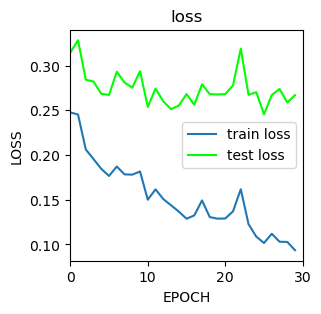

In [21]:
# 損失の可視化
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))

plt.plot(range(EPOCH), train_loss_value)
plt.plot(range(EPOCH), test_loss_value, c='#00ff00')
plt.xlim(0, EPOCH)
# plt.ylim(0, 2.5)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.savefig("loss_image.png")

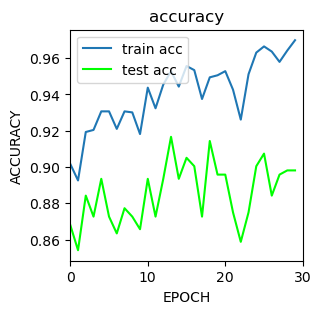

In [22]:
# 正解率の可視化
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))

plt.plot(range(EPOCH), train_acc_value)
plt.plot(range(EPOCH), test_acc_value, c='#00ff00')
plt.xlim(0, EPOCH)
# plt.ylim(0, 1)
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.legend(['train acc', 'test acc'])
plt.title('accuracy')
plt.savefig("accuracy_image.png")

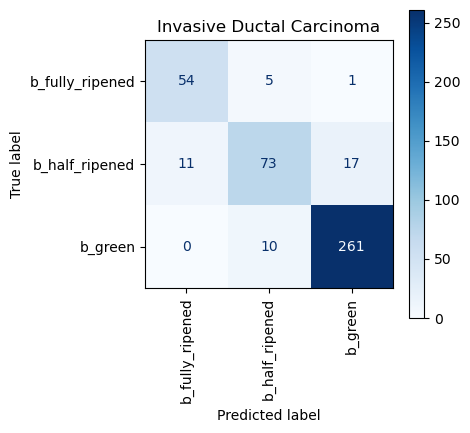

In [23]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(cm_true_list, cm_predicted_list)
cmp = ConfusionMatrixDisplay(cm, display_labels=['b_fully_ripened', 'b_half_ripened', 'b_green'])

fig, ax = plt.subplots(figsize=(4,4))
ax.set_title('Invasive Ductal Carcinoma')
cmp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)